# 4. Data cleaning
At this stage the data cleaning will be performed and will compare three imputation strategies for pv_mod1

## Setup and imports

In [1]:
import matplotlib as mpl
from functions import *
import missingno as msno
from sklearn.impute import KNNImputer

plt.style.use('seaborn-v0_8-whitegrid')

COLORS = {
    'pv': '#FFD700', # kollane
    'pv_mod1': '#FFD300', #kollane
    'pv_mod2': '#1E90FF', # oranž
    'pv_mod3': '#237823', # roheline
}

mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.size'] = 12
mpl.rcParams['axes.titlelocation'] = 'left'
mpl.rcParams['figure.dpi'] = 120
mpl.rcParams['figure.facecolor'] = 'white'
mpl.rcParams['xtick.color'] = '#333333'
mpl.rcParams['ytick.color'] = '#333333'
mpl.rcParams['axes.edgecolor'] = '#333333'
mpl.rcParams['axes.labelcolor'] = '#333333'
mpl.rcParams['axes.titlelocation'] = 'left'
mpl.rcParams['axes.grid'] = True
mpl.rcParams['grid.linestyle'] = '--'
mpl.rcParams['grid.linewidth'] = 0.5
mpl.rcParams['legend.framealpha'] = 0.9
mpl.rcParams['legend.edgecolor'] = '#444'


# Seaborn värviteema ja legendi stiil
sns.set_palette([COLORS['pv_mod1'], COLORS['pv_mod2'], COLORS['pv_mod3']])
sns.set_style("whitegrid")


## Load the data

In [2]:
df = load_data()
df.head()

,pv_mod1,pv_mod2,pv_mod3,demand,pv,price,temperature,pressure (hPa),cloud_cover (%),cloud_cover_low (%),cloud_cover_mid (%),cloud_cover_high (%),wind_speed_10m (km/h),shortwave_radiation (W/m²),direct_radiation (W/m²),diffuse_radiation (W/m²),direct_normal_irradiance (W/m²)
timestamp,,,,,,,,,,,,,,,,,
2013-07-01 00:00:00+00:00,0.0,0.0,0.0,0.27,0.0,0.01605,13.5,1011.3,4,0,0,3,10.5,NaN,0,0,0.0
2013-07-01 01:00:00+00:00,0.0,0.0,0.0,0.23,0.0,0.00095,13.2,1010.8,27,1,2,23,11.9,0.0,0,0,0.0
2013-07-01 02:00:00+00:00,0.0,0.0,0.0,0.26,0.0,0.00060,13.1,1010.3,33,0,0,32,11.6,0.0,0,0,0.0
2013-07-01 03:00:00+00:00,0.0,0.0,0.0,0.28,0.0,0.00046,13.0,1010.3,28,0,0,27,11.2,NaN,2,7,30.1
2013-07-01 04:00:00+00:00,0.0,0.0,0.0,0.29,0.0,0.00046,13.8,1010.2,16,0,1,14,11.7,NaN,30,31,252.0


## Identify missing values

In [3]:
missing_values = df.isna().sum()
print(missing_values)

pv_mod1                             438
pv_mod2                             491
pv_mod3                             510
demand                                0
pv                                    0
price                                 0
temperature                           0
pressure (hPa)                        0
cloud_cover (%)                       0
cloud_cover_low (%)                   0
cloud_cover_mid (%)                   0
cloud_cover_high (%)                  0
wind_speed_10m (km/h)                 0
shortwave_radiation (W/m²)         7095
direct_radiation (W/m²)               0
diffuse_radiation (W/m²)              0
direct_normal_irradiance (W/m²)       0
dtype: int64


In [4]:
pv_cols = ['pv_mod1', 'pv_mod2', 'pv_mod3']
missing_vals_table = df[pv_cols].isna().sum().to_frame('missing_count')
missing_vals_table['missing_%'] = (df[pv_cols].isna().mean() * 100).round(2)
save_table(missing_vals_table, 'ex4_missing_vals_table.csv')

,missing_count,missing_%
pv_mod1,438,5.00
pv_mod2,491,5.61
pv_mod3,510,5.82


In [5]:
total_cells = np.prod(df.shape)
total_missing = missing_values.sum()

# percent of data that is missing
percent_missing = round(((total_missing/total_cells) * 100), 2)
print(percent_missing)

5.73


## Figure 1. Overall missingness overview
Lets see how much data is missing for each variable in the dataset.

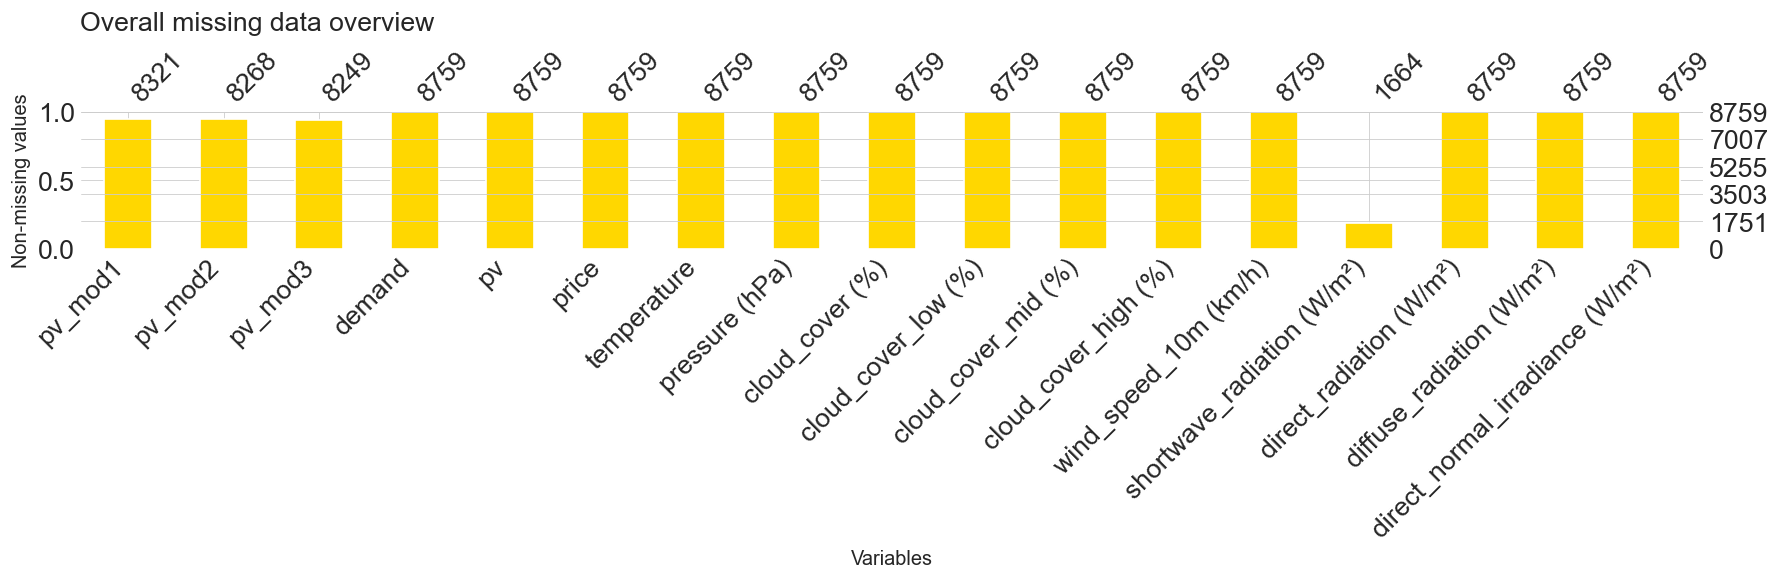

In [6]:
fig, ax = plt.subplots(figsize=(15, 5))
msno.bar(df, color=COLORS['pv'], ax=ax)
ax.set_title('Overall missing data overview', fontsize=16, pad=10)
ax.set_xlabel('Variables')
ax.set_ylabel('Non-missing values')
fig.tight_layout()
save_fig(fig, "ex4_fig1_overall_missing_data.svg")
plt.show()

## Figure 2. PV_mod1 missing data by hour of day.
This figure shows when the PV_mod1 values are missing during the day.

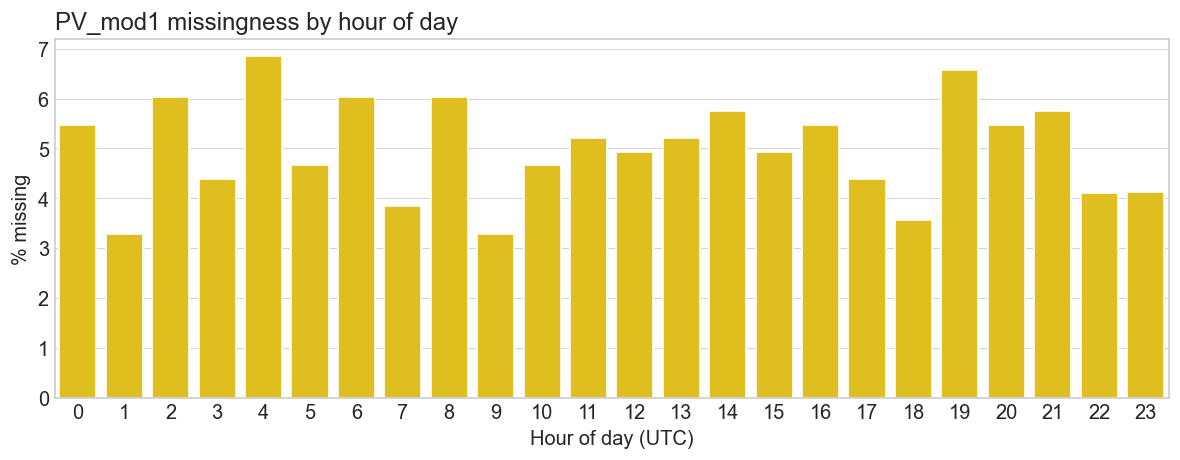

In [7]:
df['hour'] = df.index.hour
time_of_day_missing = df.groupby('hour')['pv_mod1'].apply(lambda s: s.isna().mean() * 100)
tod_missing = time_of_day_missing.reset_index(name='% missing')
fig, ax = plt.subplots(figsize=(10, 4))
sns.barplot(data=tod_missing, x='hour', y='% missing', color=COLORS['pv_mod1'], ax=ax)
ax.set_title('PV_mod1 missingness by hour of day')
ax.set_xlabel('Hour of day (UTC)')
ax.set_ylabel('% missing')
fig.tight_layout()
save_fig(fig, "ex4_fig2_missing_data_by_hour_of_day.svg")
plt.show()

## Figure 3. PV module readings during the first two weeks
The raw PV data from the three modules for a two-week period. Some gaps and sudden drops can be seen. There are short periods where one or more sensors did not record values correctly.

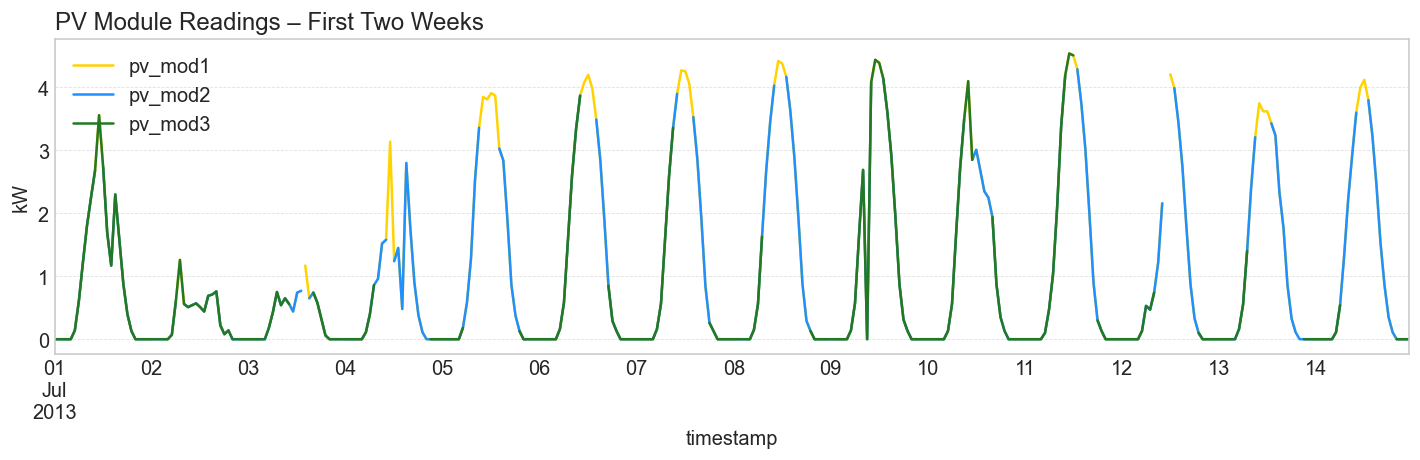

In [8]:
fig, ax = plt.subplots(figsize=(12, 4))
df[pv_cols].iloc[:24*14].plot(ax=ax)
ax.set_title("PV Module Readings – First Two Weeks")
ax.set_ylabel("kW")
ax.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
save_fig(fig, "ex4_fig3_pv_raw_timeseries.svg")
plt.show()

## Handle the missing data for the variable PV mod1 based on deletion, univariate, and multivariate imputation techniques

In [9]:
# Deletion method (remove rows, where missing pv_mod1)
pv_del = df.dropna(subset=['pv_mod1'])

# Univariate imputation (linear interpolation)
pv_uni = df.copy()
pv_uni['pv_mod1'] = pv_uni['pv_mod1'].interpolate(method='linear', limit_direction='forward')

# Multivariate imputation
pv_multi = df.copy()
imputer = KNNImputer(n_neighbors=5)
pv_multi[pv_cols] = imputer.fit_transform(pv_multi[pv_cols])

imputed_df = pd.DataFrame({
    'original': df['pv_mod1'],
    'univariate': pv_uni['pv_mod1'],
    'multivariate': pv_multi['pv_mod1']
})
imputed_df


,original,univariate,multivariate
timestamp,,,
2013-07-01 00:00:00+00:00,0.00,0.00,0.00
2013-07-01 01:00:00+00:00,0.00,0.00,0.00
2013-07-01 02:00:00+00:00,0.00,0.00,0.00
2013-07-01 03:00:00+00:00,0.00,0.00,0.00
2013-07-01 04:00:00+00:00,0.00,0.00,0.00
...,...,...,...
2014-06-30 19:00:00+00:00,0.02,0.02,0.02
2014-06-30 20:00:00+00:00,0.00,0.00,0.00
2014-06-30 21:00:00+00:00,0.00,0.00,0.00


## Numerical summary table: comparing quality of each imputed data set using PV data

In [10]:
datasets = {
    'Original': df[pv_cols],
    'Deletion': pv_del[pv_cols],
    'Univariate': pv_uni[pv_cols],
    'Multivariate': pv_multi[pv_cols],
}

summary_table = pd.DataFrame({
    name: {
        'Mean': data['pv_mod1'].mean(),
        'Variance': data['pv_mod1'].var(),
        'Std': data['pv_mod1'].std(),
        'Min': data['pv_mod1'].min(),
        'Max': data['pv_mod1'].max()
    }
    for name, data in datasets.items()
}).T

save_table(summary_table, "ex4_quality_of_each_imputed_dataset_summary.csv")
display(summary_table.round(3))

,Mean,Variance,Std,Min,Max
Original,0.660,1.225,1.107,0.0,4.81
Deletion,0.660,1.225,1.107,0.0,4.81
Univariate,0.661,1.220,1.105,0.0,4.81
Multivariate,0.658,1.219,1.104,0.0,4.81


## Figure 4. Visualisation before and after for a few representative days.
The figure compares different strategies for handling missing data in the *pv_mod1* variable over a three-day period.
- The original signal (black dashed line) contains gaps where measurements were missing.
- Deletion method (red) removes these records entirely, leading to visible discontinuities.
- Univariate linear interpolation fills gaps smoothly but slightly underestimates peaks.
- And multivariate KNN imputation provides the most realistic reconstruction by using correlated information from other PV modules.


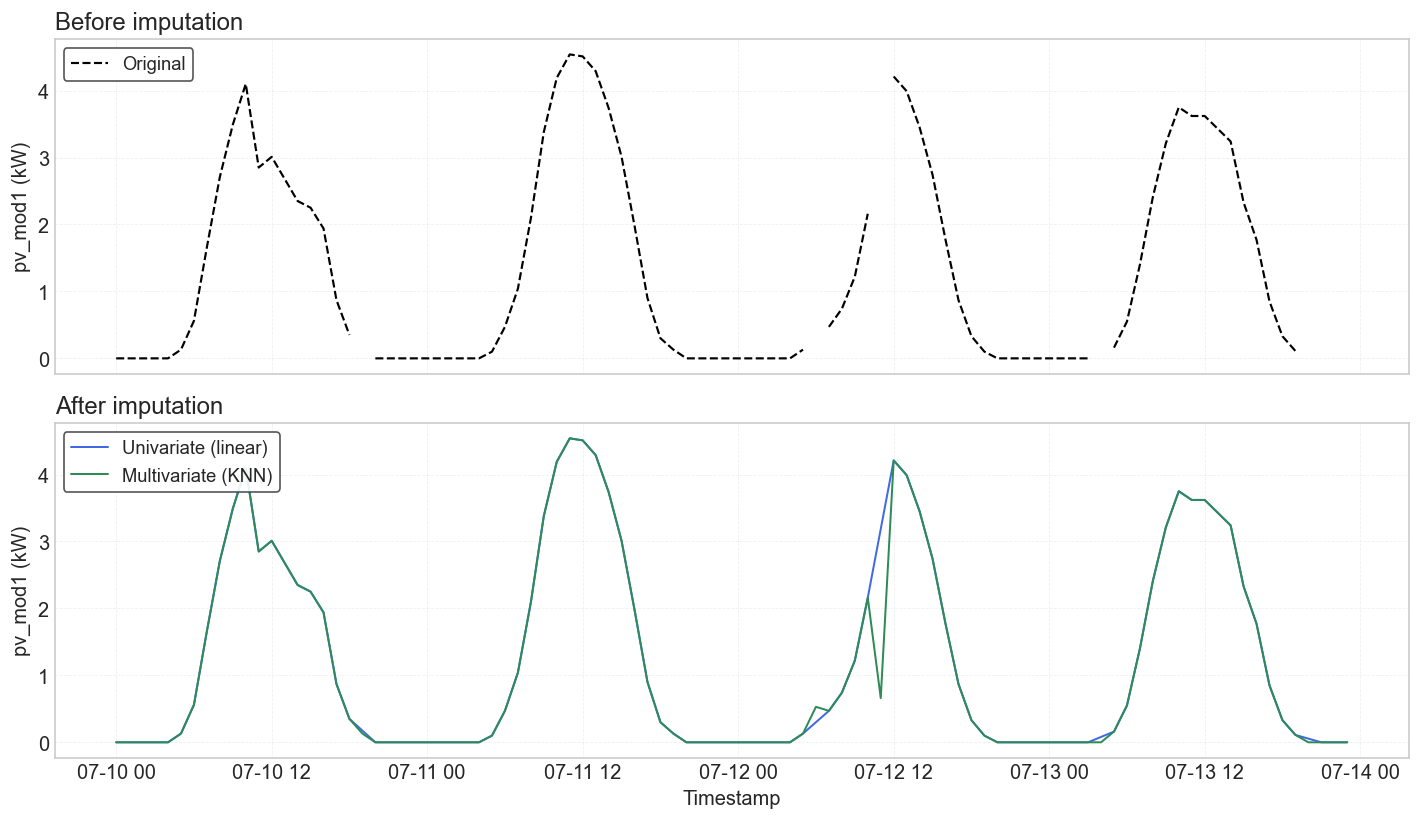

In [11]:
period = ('2013-07-10', '2013-07-13')
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 7), sharex=True)

# before
ax1.plot(df.loc[period[0]:period[1]].index,
         df.loc[period[0]:period[1], 'pv_mod1'], label='Original',
         color='black', linestyle='--', linewidth=1.3)
ax1.set_title('Before imputation')
ax1.set_ylabel('pv_mod1 (kW)')
ax1.legend(frameon=True, loc='upper left', facecolor='white', framealpha=0.9, edgecolor='#444', fontsize=11)
ax1.grid(alpha=0.3, linestyle='--')

# after
ax2.plot(pv_uni.loc[period[0]:period[1]].index,
         pv_uni.loc[period[0]:period[1], 'pv_mod1'],
         label='Univariate (linear)', color='royalblue', linewidth=1.2)
ax2.plot(pv_multi.loc[period[0]:period[1]].index,
         pv_multi.loc[period[0]:period[1], 'pv_mod1'],
         label='Multivariate (KNN)', color='seagreen', linewidth=1.2)
ax2.set_title('After imputation')
ax2.set_xlabel('Timestamp')
ax2.set_ylabel('pv_mod1 (kW)')
ax2.legend(frameon=True, loc='upper left', facecolor='white', framealpha=0.9, edgecolor='#444', fontsize=11)
ax2.grid(alpha=0.3, linestyle='--')
plt.tight_layout()
save_fig(fig, "ex4_fig4_pv_imputation.svg")
plt.show()

## Figure 5. Daily comparison of pv_mod1 imputation methods (10–13 July 2013)

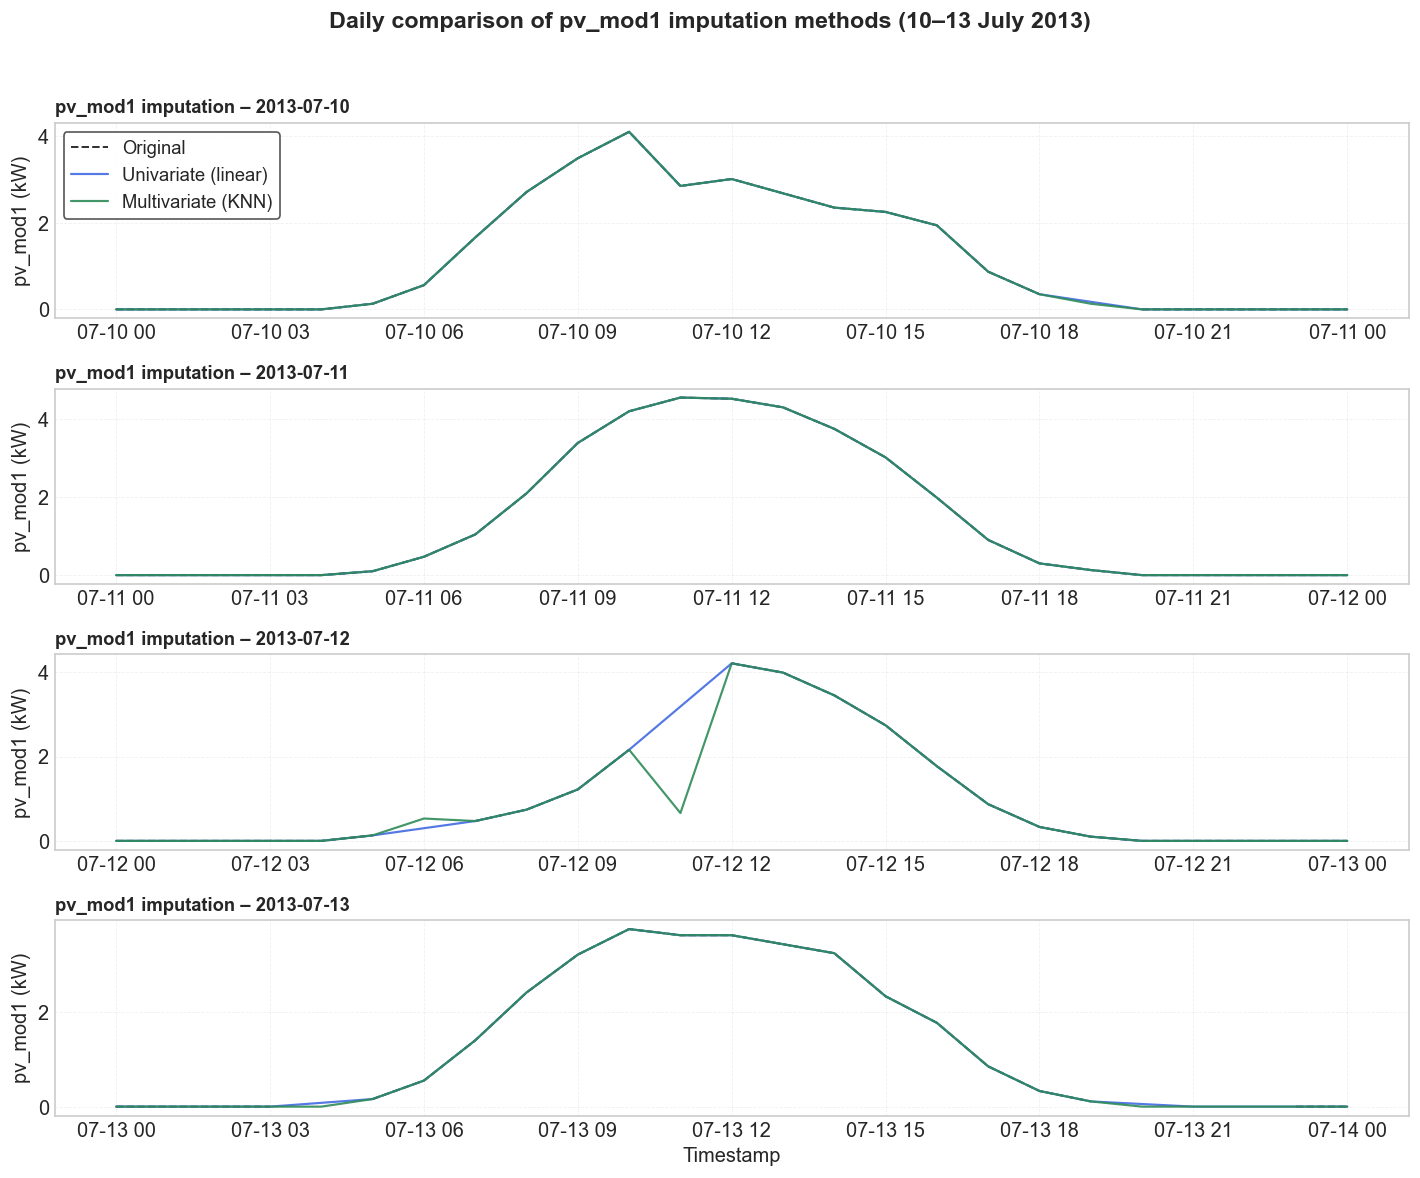

In [12]:
days = ['2013-07-10', '2013-07-11', '2013-07-12', '2013-07-13']

fig, axes = plt.subplots(len(days), 1, figsize=(12, 10), sharex=False)

for i, day in enumerate(days):
    start = pd.to_datetime(day).tz_localize('UTC')
    end = start + pd.Timedelta(days=1)

    ax = axes[i]

    # Original
    ax.plot(df.loc[start:end].index,
            df.loc[start:end, 'pv_mod1'],
            label='Original', color='black',
            linestyle='--', linewidth=1.2, alpha=0.8)

    # Univariate
    ax.plot(pv_uni.loc[start:end].index,
            pv_uni.loc[start:end, 'pv_mod1'],
            label='Univariate (linear)', color='royalblue',
            linewidth=1.3, alpha=0.9)

    # Multivariate
    ax.plot(pv_multi.loc[start:end].index,
            pv_multi.loc[start:end, 'pv_mod1'],
            label='Multivariate (KNN)', color='seagreen',
            linewidth=1.3, alpha=0.9)

    ax.set_title(f"pv_mod1 imputation – {day}", fontsize=11, weight='bold')
    ax.set_ylabel("pv_mod1 (kW)")
    ax.grid(alpha=0.3, linestyle='--')

    # Legend ainult esimesel
    if i == 0:
        ax.legend(frameon=True, loc='upper left', facecolor='white', fontsize=11)

axes[-1].set_xlabel("Timestamp")

plt.suptitle("Daily comparison of pv_mod1 imputation methods (10–13 July 2013)",
             fontsize=14, weight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.96])
save_fig(fig, "ex4_fig5_pv_imputation_several_days.svg")
plt.show()

Overall, the multivariate KNN approach preserves the daily power-generation pattern most accurately, making it the most reliable baseline for HEMS applications.